# Exercise06 : Experimentation Logs and Outputs

Here we add logging capabilities in our source code, and run / check.

*back to [index](https://github.com/tsmatz/azure-ml-tensorflow-complete-sample/Readme.md)*

## Get workspace setting

In [22]:
from azureml.core import Workspace
import azureml.core

ws = Workspace.from_config()

Found the config file in: /data/home/tsmatsuz/Tutorial/aml_config/config.json


## Create experiment

In [74]:
from azureml.core import Experiment

experiment = Experiment(workspace=ws, name='experiment_test')

## Start experiment run

In [75]:
run = experiment.start_logging()

## Change your source code and Train

Change your source code in "[Exercise03 : Just Train in Your Working Machine](https://github.com/tsmatz/azure-ml-tensorflow-complete-sample/notebooks/exercise03_train_simple.ipynb)" for logging in AML as follows. (The lines commented "##### Modified" are modified lines.)    
After running, let's go to [Azure Portal](https://portal.azure.com/) and see how logs look like in AML experiments.

In [76]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import sys
import os
import shutil
import argparse
import math

import tensorflow as tf

from azureml.core.run import Run ##### Modified

# Get run when running in remote ##### Modified
if 'run' not in locals(): ##### Modified
    run = Run.get_context() ##### Modified

FLAGS = None
batch_size = 100

#
# define functions for Estimator
#

def _my_input_fn(filepath, num_epochs):
    # image - 784 (=28 x 28) elements of grey-scaled integer value [0, 1]
    # label - digit (0, 1, ..., 9)
    data_queue = tf.train.string_input_producer(
        [filepath],
        num_epochs = num_epochs) # data is repeated and it raises OutOfRange when data is over
    data_reader = tf.TFRecordReader()
    _, serialized_exam = data_reader.read(data_queue)
    data_exam = tf.parse_single_example(
        serialized_exam,
        features={
            'image_raw': tf.FixedLenFeature([], tf.string),
            'label': tf.FixedLenFeature([], tf.int64)
        })
    data_image = tf.decode_raw(data_exam['image_raw'], tf.uint8)
    data_image.set_shape([784])
    data_image = tf.cast(data_image, tf.float32) * (1. / 255)
    data_label = tf.cast(data_exam['label'], tf.int32)
    data_batch_image, data_batch_label = tf.train.batch(
        [data_image, data_label],
        batch_size=batch_size)
    return {'inputs': data_batch_image}, data_batch_label

def _get_input_fn(filepath, num_epochs):
    return lambda: _my_input_fn(filepath, num_epochs)

def _my_model_fn(features, labels, mode):
    # with tf.device(...): # You can set device if using GPUs

    # define network and inference
    # (simple 2 fully connected hidden layer : 784->128->64->10)
    with tf.name_scope('hidden1'):
        weights = tf.Variable(
            tf.truncated_normal(
                [784, FLAGS.first_layer],
                stddev=1.0 / math.sqrt(float(784))),
            name='weights')
        biases = tf.Variable(
            tf.zeros([FLAGS.first_layer]),
            name='biases')
        hidden1 = tf.nn.relu(tf.matmul(features['inputs'], weights) + biases)
    with tf.name_scope('hidden2'):
        weights = tf.Variable(
            tf.truncated_normal(
                [FLAGS.first_layer, FLAGS.second_layer],
                stddev=1.0 / math.sqrt(float(FLAGS.first_layer))),
            name='weights')
        biases = tf.Variable(
            tf.zeros([FLAGS.second_layer]),
            name='biases')
        hidden2 = tf.nn.relu(tf.matmul(hidden1, weights) + biases)
    with tf.name_scope('softmax_linear'):
        weights = tf.Variable(
            tf.truncated_normal(
                [FLAGS.second_layer, 10],
                stddev=1.0 / math.sqrt(float(FLAGS.second_layer))),
        name='weights')
        biases = tf.Variable(
            tf.zeros([10]),
            name='biases')
        logits = tf.matmul(hidden2, weights) + biases
 
    # compute evaluation matrix
    predicted_indices = tf.argmax(input=logits, axis=1)
    if mode != tf.estimator.ModeKeys.PREDICT:
        label_indices = tf.cast(labels, tf.int32)
        accuracy = tf.metrics.accuracy(label_indices, predicted_indices)
        tf.summary.scalar('accuracy', accuracy[1]) # output to TensorBoard 
        loss = tf.losses.sparse_softmax_cross_entropy(
            labels=labels,
            logits=logits)
 
    # define operations
    if mode == tf.estimator.ModeKeys.TRAIN:
        #global_step = tf.train.create_global_step()
        #global_step = tf.contrib.framework.get_or_create_global_step()
        global_step = tf.train.get_or_create_global_step()        
        optimizer = tf.train.GradientDescentOptimizer(
            learning_rate=FLAGS.learning_rate)
        train_op = optimizer.minimize(
            loss=loss,
            global_step=global_step)
        # Ask for accuracy and loss in each steps ##### Modified
        class _CustomLoggingHook(tf.train.SessionRunHook): ##### Modified
            def begin(self): ##### Modified
                self.training_accuracy = [] ##### Modified
                self.training_loss = [] ##### Modified
            def before_run(self, run_context): ##### Modified
                return tf.train.SessionRunArgs([accuracy[1], loss, global_step]) ##### Modified
            def after_run(self, run_context, run_values): ##### Modified
                result_accuracy, result_loss, result_step = run_values.results ##### Modified
                #run.log('training_accuracy', result_accuracy) ##### Modified
                #run.log('training_loss', result_loss) ##### Modified
                self.training_accuracy.append(result_accuracy) ##### Modified
                self.training_loss.append(result_loss) ##### Modified
                if result_step % 100 == 0 : # save logs in each 100 steps ##### Modified
                    run.log_list('training_accuracy', self.training_accuracy) ##### Modified
                    run.log_list('training_loss', self.training_loss) ##### Modified
                    self.training_accuracy = [] ##### Modified
                    self.training_loss = [] ##### Modified
        return tf.estimator.EstimatorSpec(
            mode,
            training_chief_hooks=[_CustomLoggingHook()], ##### Modified
            loss=loss,
            train_op=train_op)
    if mode == tf.estimator.ModeKeys.EVAL:
        eval_metric_ops = {
            'accuracy': accuracy
        }
        return tf.estimator.EstimatorSpec(
            mode,
            loss=loss,
            eval_metric_ops=eval_metric_ops)
    if mode == tf.estimator.ModeKeys.PREDICT:
        probabilities = tf.nn.softmax(logits, name='softmax_tensor')
        predictions = {
            'classes': predicted_indices,
            'probabilities': probabilities
        }
        export_outputs = {
            'prediction': tf.estimator.export.PredictOutput(predictions)
        }
        return tf.estimator.EstimatorSpec(
            mode,
            predictions=predictions,
            export_outputs=export_outputs)

def _my_serving_input_fn():
    inputs = {'inputs': tf.placeholder(tf.float32, [None, 784])}
    return tf.estimator.export.ServingInputReceiver(inputs, inputs)

#
# Main
#

parser = argparse.ArgumentParser()
parser.add_argument(
    '--data_folder',
    type=str,
    default='./data',
    help='Folder path for input data')
parser.add_argument(
    '--chkpoint_folder',
    type=str,
    default='./logs',  # AML experiments logs folder
    help='Folder path for checkpoint files')
parser.add_argument(
    '--model_folder',
    type=str,
    default='./outputs',  # AML experiments outputs folder
    help='Folder path for model output')
parser.add_argument(
    '--learning_rate',
    type=float,
    default='0.07',
    help='Learning Rate')
parser.add_argument(
    '--first_layer',
    type=int,
    default='128',
    help='Neuron number for the first hidden layer')
parser.add_argument(
    '--second_layer',
    type=int,
    default='64',
    help='Neuron number for the second hidden layer')
FLAGS, unparsed = parser.parse_known_args()

# clean checkpoint and model folder if exists
if os.path.exists(FLAGS.chkpoint_folder) :
    for file_name in os.listdir(FLAGS.chkpoint_folder):
        file_path = os.path.join(FLAGS.chkpoint_folder, file_name)
        if os.path.isfile(file_path):
            os.remove(file_path)
        elif os.path.isdir(file_path):
            shutil.rmtree(file_path)
if os.path.exists(FLAGS.model_folder) :
    for file_name in os.listdir(FLAGS.model_folder):
        file_path = os.path.join(FLAGS.model_folder, file_name)
        if os.path.isfile(file_path):
            os.remove(file_path)
        elif os.path.isdir(file_path):
            shutil.rmtree(file_path)

# read TF_CONFIG
run_config = tf.contrib.learn.RunConfig()

# create Estimator
mnist_fullyconnected_classifier = tf.estimator.Estimator(
    model_fn=_my_model_fn,
    model_dir=FLAGS.chkpoint_folder,
    config=run_config)
train_spec = tf.estimator.TrainSpec(
    input_fn=_get_input_fn(os.path.join(FLAGS.data_folder, 'train.tfrecords'), 2),
    max_steps=60000 * 2 / batch_size)
eval_spec = tf.estimator.EvalSpec(
    input_fn=_get_input_fn(os.path.join(FLAGS.data_folder, 'test.tfrecords'), 1),
    steps=10000 * 1 / batch_size,
    start_delay_secs=0)

# run !
eval_res = tf.estimator.train_and_evaluate(
    mnist_fullyconnected_classifier,
    train_spec,
    eval_spec
)

# save model and variables
model_dir = mnist_fullyconnected_classifier.export_savedmodel(
    export_dir_base = FLAGS.model_folder,
    serving_input_receiver_fn = _my_serving_input_fn)
print('current working directory is ', os.getcwd())
print('model is saved ', model_dir)

# send logs to AML ##### Modified   
run.log('learning_rate', FLAGS.learning_rate) ##### Modified
run.log('1st_layer', FLAGS.first_layer) ##### Modified
run.log('2nd_layer', FLAGS.second_layer) ##### Modified
run.log('final_accuracy', eval_res[0]['accuracy']) ##### Modified
run.log('final_loss', eval_res[0]['loss']) ##### Modified

INFO:tensorflow:Using config: {'_task_type': None, '_task_id': 0, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fbf77577128>, '_master': '', '_num_ps_replicas': 0, '_num_worker_replicas': 0, '_environment': 'local', '_is_chief': True, '_evaluation_master': '', '_train_distribute': None, '_eval_distribute': None, '_device_fn': None, '_tf_config': gpu_options {
  per_process_gpu_memory_fraction: 1.0
}
, '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_secs': 600, '_log_step_count_steps': 100, '_protocol': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_save_checkpoints_steps': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_model_dir': './logs'}
INFO:tensorflow:Running training and evaluation locally (non-distributed).
INFO:tensorflow:Start train and evaluate loop. The evaluate will happen after every checkpoint. Checkp

AsyncTask(post)

## Stop Run

In [77]:
run.complete()

## Show logs using AML run history widget

You can also view your logs in your notebook. (For viewing in your notebook, you must install extensions on your jupyter server. See [Readme](https://github.com/tsmatz/azure-ml-tensorflow-complete-sample/Readme.md).)

In [78]:
from azureml.train.widgets import RunDetails
RunDetails(run_instance=run).show()

_UserRun(widget_settings={'childWidgetDisplay': 'popup'})

## Plot by code

You can also explorer using python code and plot as you like.

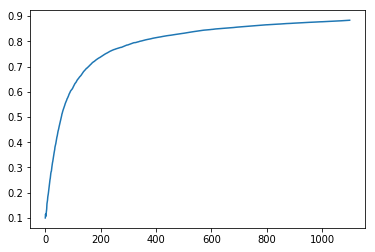

In [15]:
import matplotlib.pyplot as plt
metrics = run.get_metrics()
plt.plot(metrics['training_accuracy'])